# Name2Vec

Importing all libraries

In [1]:
import psycopg2
import matplotlib.pyplot as plt
import pandas.io.sql as psql
from gensim.models.word2vec import Word2Vec
import numpy as np
from gensim import corpora, models, similarities,matutils
from sklearn import cluster, datasets
import sklearn.manifold as mn
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import spectral_clustering
%matplotlib inline

Database connection : Cern Dataset

In [138]:
conn = psycopg2.connect(database="cern", user="postgres", password="dmkm1234", host="localhost", port=5432)
dataframe = psql.read_sql("select _authors from public.records ;", conn)

In [4]:
dataframe.head()

,_authors
0,"[u'Miller, Roger H.']"
1,"[u'Noyes, H.Pierre']"
2,"[u'Berman, S.M.', u'Drell, S.D.']"
3,"[u'Berman, S.M.', u'Drell, S.D.']"
4,"[u'Altenmueller, Otto H.', u'Larsen, Rudolf R...."


In [5]:
def nameprocess(data):
    import ast 
    name = ast.literal_eval(data)
    return name

In [6]:
nameproc  = dataframe['_authors'].apply(lambda x : nameprocess(x))

Building vector representations of names

In [7]:
min_count = 1
size = 100
window = 2000
workers = 8
model = Word2Vec(nameproc, min_count=min_count, size=size, window=window,sg=0,workers=workers)

In [8]:
# Time taken to train the model around 30 mins
model.total_train_time

1469.988373041153

Saving the model

In [9]:
model.save('name2vec.bin')

In [7]:
model = Word2Vec.load('name2vec.bin')

In [8]:
matrix = similarities.MatrixSimilarity(matutils.Dense2Corpus(model.syn0))
matrix.index.shape

(100, 268057)

Clustering

In [20]:
k_means = cluster.KMeans(n_clusters=3)
train = k_means.fit(matrix.index.T)
cluster_labels = train.labels_

In this plot we see imbalance in the clusters

(array([ 243253.,       0.,       0.,       0.,       0.,    5930.,
              0.,       0.,       0.,   18874.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

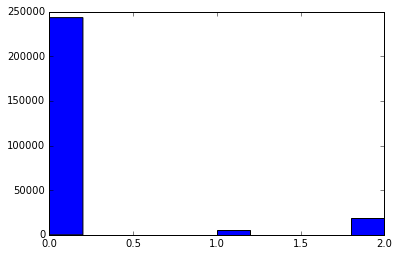

In [26]:
plt.hist(cluster_labels)

In [27]:
labels =[]
tokensdim = []
for word in model.vocab:
    tokensdim.append(model[word])
    labels.append(word)

In [28]:
from sklearn.utils import shuffle
X, Y = shuffle(labels, tokensdim, random_state=100)

In [29]:
tnse_model = mn.TSNE(perplexity = 10,n_components=2,init='pca',n_iter=200)
new_val = tnse_model.fit_transform(Y[:200])
x =[]
y = []
for value in new_val:
    x.append(value[0])
    y.append(value[1])

TSNE plot

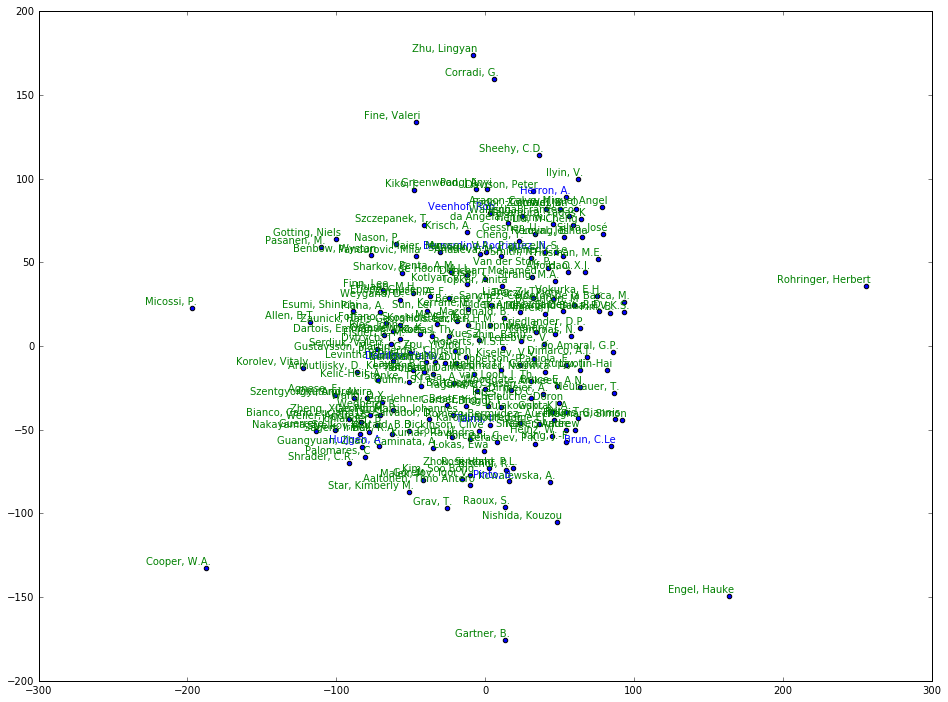

In [31]:
plt.figure(figsize=(16,12))
for i in range(200):
    if cluster_labels[i] == 1:
        col ='blue'
    if cluster_labels[i] == 2:
        col = 'green'
    if cluster_labels[i] == 3:
        col = 'red'
        
    plt.scatter(x[i],y[i])
    plt.annotate(X[i],
                xy = (x[i],y[i]),
                xytext = (5,2),
                textcoords ='offset points',
                ha = 'right',
                va = 'bottom',color=col)
plt.show()